In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
real_gtf = pd.read_csv(base_dir_data+"real.gtf",sep="\t",names=gff3cols)
real_gtf["tid_real"] = real_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splice_gtf = pd.read_csv(base_dir_data+"splicing.gtf",sep="\t",names=gff3cols)
splice_gtf["tid_splicing"] = splice_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
int_gtf = pd.read_csv(base_dir_data+"intronic.gtf",sep="\t",names=gff3cols)
int_gtf["tid_intronic"] = int_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
pol_gtf = pd.read_csv(base_dir_data+"RNApol.gtf",sep="\t",names=gff3cols)
pol_gtf["tid_intergenic"] = pol_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]

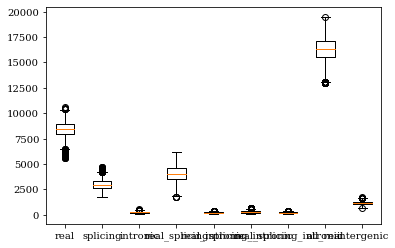

In [7]:
# based on the number of loci per sample
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")

for label in s_loc.columns:
    # now we shall remove any outliers from the data
    q25,q50,q75 = s_loc[label].quantile([0.25,0.5,0.75])
    iqr = q75-q25
    thw = q75+1.5*iqr
    tlw = q25-1.5*iqr
    ahw = s_loc[s_loc[label]<=thw][label].max()
    alw = s_loc[s_loc[label]>=tlw][label].min()
    s_loc = s_loc[(s_loc[label]<=ahw)&(s_loc[label]>=alw)].reset_index(drop=True)

fig,ax = plt.subplots()
ax.boxplot(s_loc.T,labels=s_loc.T.index.tolist())
plt.show()

In [56]:
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    realDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.real_t"+str(tissue_num))
    spliceDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.splice_t"+str(tissue_num))
    intDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.int_t"+str(tissue_num))
    polDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.pol_t"+str(tissue_num))
    
    print("starting number of real loci: "+str(len(set(realDF["lid"]))))
    print("starting number of splicing loci: "+str(len(set(spliceDF["lid"]))))
    print("starting number of intronic loci: "+str(len(set(intDF["lid"]))))
    print("starting number of intergenic loci: "+str(len(set(polDF["lid"]))))
    
    for sample_num in range(num_samples):
        print("++++++\n>Sample #"+str(sample_num)+"\n++++++\n")
        # ==================================
        # get numbers
        # ==================================
        realn,splicen,intn,real_splicen,real_intn,splice_intn,real_splice_intn,all_realn,poln = s_loc.sample()[["real",\
                                                                                                                "splicing",\
                                                                                                                "intronic",\
                                                                                                                "real_splicing",\
                                                                                                                "real_intronic",\
                                                                                                                "splicing_intronic",\
                                                                                                                "real_splicing_intronic",\
                                                                                                                "all_real",\
                                                                                                                "intergenic"]].iloc[0].tolist()
        
        # ==================================
        # Now to generate sample from tissue
        # for intergenic set
        # ==================================
        
        # now let's split this into samples the old way
        # now let's split this into samples the old way
        realDF_g = realDF.groupby("lid").agg({"tid_real":{"tids_real":lambda x:list(x),
                                                                "count_real":"count"},
                                              "real_tpms":"first"}).reset_index()
        realDF_g.columns = ["lid","tids_real","count_real","real_tpms"]
        realDF_g["real_tpms"] = realDF_g["real_tpms"].str.split(";")

        # now let's split this into samples the old way
        spliceDF_g = spliceDF.groupby("lid").agg({"tid_splicing":{"tids_splicing":lambda x:list(x),
                                                                "count_splicing":"count"},
                                              "splicing_tpms":"first"}).reset_index()
        spliceDF_g.columns = ["lid","tids_splicing","count_splicing","splicing_tpms"]
        spliceDF_g["splicing_tpms"] = spliceDF_g["splicing_tpms"].str.split(";")

        # now let's split this into samples the old way
        intDF_g = intDF.groupby("lid").agg({"tid_intronic":{"tids_intronic":lambda x:list(x),
                                                                "count_intronic":"count"},
                                              "intronic_tpms":"first"}).reset_index()
        intDF_g.columns = ["lid","tids_intronic","count_intronic","intronic_tpms"]
        intDF_g["intronic_tpms"] = intDF_g["intronic_tpms"].str.split(";")

        # now let's split this into samples the old way
        polDF_g = polDF.groupby("lid").agg({"tid_intergenic":{"tids_intergenic":lambda x:list(x),
                                                                "count_intergenic":"count"},
                                              "intergenic_tpms":"first"}).reset_index()
        polDF_g.columns = ["lid","tids_intergenic","count_intergenic","intergenic_tpms"]
        polDF_g["intergenic_tpms"] = polDF_g["intergenic_tpms"].str.split(";")

        all_g_lid = realDF_g.merge(spliceDF_g,how="outer",on="lid")
        all_g_lid = all_g_lid.merge(intDF_g,how="outer",on="lid")
        all_g_lid = all_g_lid.merge(polDF_g,how="outer",on="lid")
        all_g_lid["count_real"] = all_g_lid["count_real"].fillna(0)
        all_g_lid["count_splicing"] = all_g_lid["count_splicing"].fillna(0)
        all_g_lid["count_intronic"] = all_g_lid["count_intronic"].fillna(0)
        all_g_lid["count_intergenic"] = all_g_lid["count_intergenic"].fillna(0)

        all_g_lid["count_real"]=all_g_lid["count_real"].astype(int)
        all_g_lid["count_splicing"]=all_g_lid["count_splicing"].astype(int)
        all_g_lid["count_intronic"]=all_g_lid["count_intronic"].astype(int)
        all_g_lid["count_intergenic"]=all_g_lid["count_intergenic"].astype(int)

        all_g_lid.fillna("",inplace=True)

        # need a function to get the samples from this now
        lids_intergenic=[]
        tids_intergenic=[]
        tpms_intergenic=[]

        lids_real=[]
        tids_real=[]
        tpms_real=[]

        lids_splicing=[]
        tids_splicing=[]
        tpms_splicing=[]

        lids_intronic=[]
        tids_intronic=[]
        tpms_intronic=[]

        def get_samples(row):
            global lids_intergenic
            global tids_intergenic
            global tpms_intergenic
            if(row["count_intergenic"]>0):
                all_intergenic_tids = np.array(row["tids_intergenic"])
                all_intergenic_tpms = row["intergenic_tpms"]
                # randomly choose a sample
                rand_sample_idx = random.randint(0,len(all_intergenic_tpms)-1)
                tmp_tpms = all_intergenic_tpms[rand_sample_idx].split("-")
                tid_ids = []
                res_tpms = []
                for i in range(len(tmp_tpms)):
                    if not tmp_tpms[i]=="0":
                        tid_ids.append(i)
                        res_tpms.append(float(tmp_tpms[i]))
                res_tids = all_intergenic_tids[tid_ids]
                lids_intergenic.extend([row["lid"] for i in range(len(res_tids))])
                tids_intergenic.extend(res_tids)
                tpms_intergenic.extend(res_tpms)
            else:
                all_real_tpms = row["real_tpms"]
                all_splicing_tpms = row["splicing_tpms"]
                all_intronic_tpms = row["intronic_tpms"]

                all_real_tids = np.array(row["tids_real"])
                all_splicing_tids = np.array(row["tids_splicing"])
                all_intronic_tids = np.array(row["tids_intronic"])

                num_observations = max(len(all_real_tpms),len(all_splicing_tpms),len(all_intronic_tpms))
                rand_sample_idx = random.randint(0,num_observations-1)

                if row["count_real"]>0:
                    assert len(all_real_tpms)==num_observations
                    tmp_tpms = all_real_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_real_tids[tid_ids]
                    lids_real.extend([row["lid"] for i in range(len(res_tids))])
                    tids_real.extend(res_tids)
                    tpms_real.extend(res_tpms)
                if row["count_splicing"]>0:
                    assert len(all_splicing_tpms)==num_observations
                    tmp_tpms = all_splicing_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_splicing_tids[tid_ids]
                    lids_splicing.extend([row["lid"] for i in range(len(res_tids))])
                    tids_splicing.extend(res_tids)
                    tpms_splicing.extend(res_tpms)
                if row["count_intronic"]>0:
                    assert len(all_intronic_tpms)==num_observations
                    tmp_tpms = all_intronic_tpms[rand_sample_idx].split("-")
                    tid_ids = []
                    res_tpms = []
                    for i in range(len(tmp_tpms)):
                        if not tmp_tpms[i]=="0":
                            tid_ids.append(i)
                            res_tpms.append(float(tmp_tpms[i]))
                    res_tids = all_intronic_tids[tid_ids]
                    lids_intronic.extend([row["lid"] for i in range(len(res_tids))])
                    tids_intronic.extend(res_tids)
                    tpms_intronic.extend(res_tpms)

        all_g_lid.apply(lambda row: get_samples(row),axis=1)
        
        print("number of real transcripts: "+str(len(set(tids_real))))
        print("number of splicing transcripts: "+str(len(set(tids_splicing))))
        print("number of intronic transcripts: "+str(len(set(tids_intronic))))
        print("number of intergenic transcripts: "+str(len(set(tids_intergenic))))
        print("number of real genes: "+str(len(set(lids_real))))
        print("number of solicing genes: "+str(len(set(lids_splicing))))
        print("number of intronic genes: "+str(len(set(lids_intronic))))
        print("number of intergenic genes: "+str(len(set(lids_intergenic))))

        print("targeting "+str(realn)+" real only loci")
        print("targeting "+str(splicen)+" splicing only loci")
        print("targeting "+str(intn)+" intronic only loci")
        print("targeting "+str(real_splicen)+" real and splicing loci")
        print("targeting "+str(real_intn)+" real and intronic loci")
        print("targeting "+str(splice_intn)+" splicing and intronic loci")
        print("targeting "+str(real_splice_intn)+" real and splicing and intronic loci")
        print("targeting "+str(poln)+" intergenic loci")

        real_sample_locs = set(lids_real)
        splicing_sample_locs = set(lids_splicing)
        intronic_sample_locs = set(lids_intronic)
        intergenic_sample_locs = list(set(lids_intergenic))

        real_only_sample_locs = list(real_sample_locs-(splicing_sample_locs.union(intronic_sample_locs)))
        splicing_only_sample_locs = list(splicing_sample_locs-(real_sample_locs.union(intronic_sample_locs)))
        intronic_only_sample_locs = list(intronic_sample_locs-(real_sample_locs.union(splicing_sample_locs)))

        real_splicing_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs)-intronic_sample_locs)
        real_intronic_sample_locs = list(real_sample_locs.intersection(intronic_sample_locs)-splicing_sample_locs)
        splicing_intronic_sample_locs = list(splicing_sample_locs.intersection(intronic_sample_locs)-real_sample_locs)

        real_splicing_intronic_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs.intersection(intronic_sample_locs)))

        print("available real only loci: "+str(len(real_only_sample_locs)))
        print("available splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("available intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("available real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("available real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("available splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("available real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
        print("available intergenic only loci: "+str(len(intergenic_sample_locs)))

        random.shuffle(real_only_sample_locs)
        min_realn = min(len(real_only_sample_locs),realn)
        real_only_sample_locs = real_only_sample_locs[:min_realn]
        random.shuffle(splicing_only_sample_locs)
        min_splicen = min(len(splicing_only_sample_locs),splicen)
        splicing_only_sample_locs = splicing_only_sample_locs[:min_splicen]
        random.shuffle(intronic_only_sample_locs)
        min_intn = min(len(intronic_only_sample_locs),intn)
        intronic_only_sample_locs = intronic_only_sample_locs[:min_intn]
        random.shuffle(intergenic_sample_locs)
        min_poln = min(len(intergenic_sample_locs),poln)
        intergenic_sample_locs = intergenic_sample_locs[:min_poln]

        random.shuffle(real_splicing_sample_locs)
        min_real_splicen = min(len(real_splicing_sample_locs),real_splicen)
        real_splicing_sample_locs = real_splicing_sample_locs[:min_real_splicen]
        random.shuffle(real_intronic_sample_locs)
        min_real_intn = min(len(real_intronic_sample_locs),real_intn)
        real_intronic_sample_locs = real_intronic_sample_locs[:min_real_intn]
        random.shuffle(splicing_intronic_sample_locs)
        min_splice_intn = min(len(splicing_intronic_sample_locs),splice_intn)
        splicing_intronic_sample_locs = splicing_intronic_sample_locs[:min_splice_intn]

        random.shuffle(real_splicing_intronic_sample_locs)
        min_real_splice_intn = min(len(real_splicing_intronic_sample_locs),real_splice_intn)
        real_splicing_intronic_sample_locs = real_splicing_intronic_sample_locs[:min_real_splice_intn]

        print("selecting real only loci: "+str(len(real_only_sample_locs)))
        print("selecting splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("selecting intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("selecting real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("selecting real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("selecting splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("selecting real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
        print("selecting intergenic loci: "+str(len(intergenic_sample_locs)))
        
        real_sub = pd.concat([pd.DataFrame(lids_real,columns=["lid"]),pd.DataFrame(tids_real,columns=["tid"]),pd.DataFrame(tpms_real,columns=["tpm"])],axis=1)
        splicing_sub = pd.concat([pd.DataFrame(lids_splicing,columns=["lid"]),pd.DataFrame(tids_splicing,columns=["tid"]),pd.DataFrame(tpms_splicing,columns=["tpm"])],axis=1)
        intronic_sub = pd.concat([pd.DataFrame(lids_intronic,columns=["lid"]),pd.DataFrame(tids_intronic,columns=["tid"]),pd.DataFrame(tpms_intronic,columns=["tpm"])],axis=1)
        intergenic_sub = pd.concat([pd.DataFrame(lids_intergenic,columns=["lid"]),pd.DataFrame(tids_intergenic,columns=["tid"]),pd.DataFrame(tpms_intergenic,columns=["tpm"])],axis=1)
        
        real_only_sample_df = real_sub[real_sub["lid"].isin(real_only_sample_locs)].reset_index(drop=True)
        splicing_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_only_sample_locs)].reset_index(drop=True)
        intronic_only_sample_df = intronic_sub[intronic_sub["lid"].isin(intronic_only_sample_locs)].reset_index(drop=True)
        intergenic_sub2 = intergenic_sub[intergenic_sub["lid"].isin(intergenic_sample_locs)].reset_index(drop=True)

        real_splicing_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)
        splicing_real_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)

        real_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)

        splicing_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)

        real_splicing_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        splicing_real_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)

        real_sub2 = pd.concat([real_only_sample_df,\
                               real_splicing_only_sample_df,\
                               real_intronic_only_sample_df,\
                               real_splicing_intronic_only_sample_df],axis=0).reset_index(drop=True)
        splicing_sub2 = pd.concat([splicing_only_sample_df,\
                                   splicing_real_only_sample_df,\
                                   splicing_intronic_only_sample_df,\
                                   splicing_real_intronic_only_sample_df],axis=0).reset_index(drop=True)
        intronic_sub2 = pd.concat([intronic_only_sample_df,\
                                   intronic_real_only_sample_df,\
                                   intronic_splicing_only_sample_df,\
                                   intronic_real_splicing_only_sample_df],axis=0).reset_index(drop=True)

        print("final number of real transcripts: "+str(len(set(real_sub2["tid"]))))
        print("final number of splicing transcripts: "+str(len(set(splicing_sub2["tid"]))))
        print("final number of intronic transcripts: "+str(len(set(intronic_sub2["tid"]))))
        print("final number of intergenic transcripts: "+str(len(set(intergenic_sub2["tid"]))))
        print("final number of real loci: "+str(len(set(real_sub2["lid"]))))
        print("final number of splicing loci: "+str(len(set(splicing_sub2["lid"]))))
        print("final number of intronic loci: "+str(len(set(intronic_sub2["lid"]))))
        print("final number of intergenic loci: "+str(len(set(intergenic_sub2["lid"]))))

        ttx_real = list(real_sub2["tid"])
        tpm_real = list(real_sub2["tpm"])

        ttx_splice = list(splicing_sub2["tid"])
        tpm_splice = list(splicing_sub2["tpm"])

        ttx_int = list(intronic_sub2["tid"])
        tpm_int = list(intronic_sub2["tpm"])

        ttx_intergenic = list(intergenic_sub2["tid"])
        tpm_intergenic = list(intergenic_sub2["tpm"])

        # now we can save the results
        res_real = pd.concat([pd.DataFrame(ttx_real,columns=["tid_real"]),pd.DataFrame(tpm_real,columns=["tpm"])],axis=1)
        realDF_f = realDF[["lid","tid_real"]].merge(res_real,on="tid_real",how="inner")
        realDF_f = real_gtf.merge(realDF_f[["tid_real","tpm"]],on="tid_real",how="inner")
        realDF_f["attributes"] = realDF_f["attributes"].str.rstrip(";")+\
                                    ";sim_tpm="+realDF_f["tpm"].astype(str)
        realDF_f[gff3cols].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        realDF_f[realDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)

        res_splicing = pd.concat([pd.DataFrame(ttx_splice,columns=["tid_splicing"]),pd.DataFrame(tpm_splice,columns=["tpm"])],axis=1)
        splicingDF_f = spliceDF[["lid","tid_splicing"]].merge(res_splicing,on="tid_splicing",how="inner")
        splicingDF_f = splice_gtf.merge(splicingDF_f[["tid_splicing","tpm"]],on="tid_splicing",how="inner")
        splicingDF_f["attributes"] = splicingDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+splicingDF_f["tpm"].astype(str)
        splicingDF_f[gff3cols].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        splicingDF_f[splicingDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
        splicingDF_f.head()

        res_intronic = pd.concat([pd.DataFrame(ttx_int,columns=["tid_intronic"]),pd.DataFrame(tpm_int,columns=["tpm"])],axis=1)
        intronicDF_f = intDF[["lid","tid_intronic"]].merge(res_intronic,on="tid_intronic",how="inner")
        intronicDF_f = int_gtf.merge(intronicDF_f[["tid_intronic","tpm"]],on="tid_intronic",how="inner")
        intronicDF_f["attributes"] = intronicDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+intronicDF_f["tpm"].astype(str)
        intronicDF_f[gff3cols].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        intronicDF_f[intronicDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)

        res_intergenic = pd.concat([pd.DataFrame(ttx_intergenic,columns=["tid_intergenic"]),pd.DataFrame(tpm_intergenic,columns=["tpm"])],axis=1)
        intergenicDF_f = polDF[["lid","tid_intergenic"]].merge(res_intergenic,on="tid_intergenic",how="inner")
        intergenicDF_f = pol_gtf.merge(intergenicDF_f[["tid_intergenic","tpm"]],on="tid_intergenic",how="inner")
        intergenicDF_f["attributes"] = intergenicDF_f["attributes"].str.rstrip(";")+\
                                    ";sim_tpm="+intergenicDF_f["tpm"].astype(str)
        intergenicDF_f[gff3cols].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        intergenicDF_f[intergenicDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)



Tissue #0

starting number of real loci: 31218
starting number of splicing loci: 25878
starting number of intronic loci: 14519
starting number of intergenic loci: 29016
++++++
>Sample #0
++++++

number of real transcripts: 39411
number of splicing transcripts: 20351
number of intronic transcripts: 4217
number of intergenic transcripts: 29423
number of real genes: 20912
number of solicing genes: 13163
number of intronic genes: 2951
number of intergenic genes: 29013
targeting 7389 real only loci
targeting 3436 splicing only loci
targeting 286 intronic only loci
targeting 4023 real and splicing loci
targeting 285 real and intronic loci
targeting 481 splicing and intronic loci
targeting 233 real and splicing and intronic loci
targeting 1026 intergenic loci
available real only loci: 16127
available splicing only loci: 8015
available intronic only loci: 1550
available real and splicing loci: 4120
available real and intronic loci: 373
available splicing and intronic loci: 736
available real 

final number of real transcripts: 21785
final number of splicing transcripts: 9021
final number of intronic transcripts: 797
final number of intergenic transcripts: 955
final number of real loci: 10983
final number of splicing loci: 5603
final number of intronic loci: 559
final number of intergenic loci: 941
++++++
>Sample #6
++++++

number of real transcripts: 39547
number of splicing transcripts: 20481
number of intronic transcripts: 4146
number of intergenic transcripts: 29396
number of real genes: 20798
number of solicing genes: 13292
number of intronic genes: 2981
number of intergenic genes: 29013
targeting 8722 real only loci
targeting 2493 splicing only loci
targeting 157 intronic only loci
targeting 2867 real and splicing loci
targeting 110 real and intronic loci
targeting 81 splicing and intronic loci
targeting 56 real and splicing and intronic loci
targeting 918 intergenic loci
available real only loci: 15973
available splicing only loci: 8097
available intronic only loci: 15

final number of real transcripts: 19195
final number of splicing transcripts: 10167
final number of intronic transcripts: 1447
final number of intergenic transcripts: 899
final number of real loci: 9268
final number of splicing loci: 6455
final number of intronic loci: 880
final number of intergenic loci: 886
++++++
>Sample #2
++++++

number of real transcripts: 37735
number of splicing transcripts: 19295
number of intronic transcripts: 4042
number of intergenic transcripts: 29367
number of real genes: 19742
number of solicing genes: 12597
number of intronic genes: 2830
number of intergenic genes: 29016
targeting 7901 real only loci
targeting 2622 splicing only loci
targeting 179 intronic only loci
targeting 3058 real and splicing loci
targeting 154 real and intronic loci
targeting 146 splicing and intronic loci
targeting 94 real and splicing and intronic loci
targeting 920 intergenic loci
available real only loci: 15124
available splicing only loci: 7649
available intronic only loci: 

final number of real transcripts: 26882
final number of splicing transcripts: 12011
final number of intronic transcripts: 1537
final number of intergenic transcripts: 1252
final number of real loci: 12752
final number of splicing loci: 7335
final number of intronic loci: 1052
final number of intergenic loci: 1236
++++++
>Sample #8
++++++

number of real transcripts: 37640
number of splicing transcripts: 19604
number of intronic transcripts: 4018
number of intergenic transcripts: 29390
number of real genes: 19761
number of solicing genes: 12654
number of intronic genes: 2830
number of intergenic genes: 29016
targeting 7053 real only loci
targeting 2980 splicing only loci
targeting 318 intronic only loci
targeting 4828 real and splicing loci
targeting 297 real and intronic loci
targeting 457 splicing and intronic loci
targeting 385 real and splicing and intronic loci
targeting 1157 intergenic loci
available real only loci: 15081
available splicing only loci: 7641
available intronic only 

final number of real transcripts: 24650
final number of splicing transcripts: 11987
final number of intronic transcripts: 1458
final number of intergenic transcripts: 1245
final number of real loci: 11948
final number of splicing loci: 7413
final number of intronic loci: 991
final number of intergenic loci: 1232
++++++
>Sample #4
++++++

number of real transcripts: 33022
number of splicing transcripts: 16928
number of intronic transcripts: 3529
number of intergenic transcripts: 29342
number of real genes: 17388
number of solicing genes: 10939
number of intronic genes: 2440
number of intergenic genes: 29015
targeting 8775 real only loci
targeting 2703 splicing only loci
targeting 181 intronic only loci
targeting 3716 real and splicing loci
targeting 156 real and intronic loci
targeting 161 splicing and intronic loci
targeting 133 real and splicing and intronic loci
targeting 1060 intergenic loci
available real only loci: 13306
available splicing only loci: 6603
available intronic only l

final number of real transcripts: 25416
final number of splicing transcripts: 11442
final number of intronic transcripts: 1936
final number of intergenic transcripts: 1376
final number of real loci: 12276
final number of splicing loci: 6963
final number of intronic loci: 1209
final number of intergenic loci: 1371


In [39]:
# as seen in test.ipynb we currently have duplicate transcripts in the file
# this needs to be fixed!!!
realDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.real_t2")
spliceDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.splice_t2")
intDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.int_t2")
polDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.pol_t2")
realDF.head()

,lid,tid_real,real_tpms
0,CHS.1,CHS.1.1,0;0;0;0;0;0.68;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1.0...
1,CHS.100,CHS.100.2,0-0-0;0-0-0.42;0-0-3.04;0.44-0-1.11;0-2.05-0;0...
2,CHS.100,CHS.100.4,NaN
3,CHS.100,CHS.100.5,NaN
4,CHS.10000,CHS.10000.12,0-0-9.23-0-0-0-0-0;0-2.73-3.86-0-0-0-0-0;0-0-6...


In [40]:
realDF[realDF["tid_real"]=="CHS.3.2"]

,lid,tid_real,real_tpms
39868,CHS.3,CHS.3.2,9.40;8.90;19.33;16.20;10.71;9.26;12.01;18.20;2...


In [41]:
realn,splicen,intn,real_splicen,real_intn,splice_intn,real_splice_intn,all_realn,poln = s_loc.sample()[["real",\
                                                                                                        "splicing",\
                                                                                                        "intronic",\
                                                                                                        "real_splicing",\
                                                                                                        "real_intronic",\
                                                                                                        "splicing_intronic",\
                                                                                                        "real_splicing_intronic",\
                                                                                                        "all_real",\
                                                                                                        "intergenic"]].iloc[0].tolist()

# ==================================
# Now to generate sample from tissue
# for intergenic set
# ==================================

# now let's split this into samples the old way
# now let's split this into samples the old way
realDF_g = realDF.groupby("lid").agg({"tid_real":{"tids_real":lambda x:list(x),
                                                        "count_real":"count"},
                                      "real_tpms":"first"}).reset_index()
realDF_g.columns = ["lid","tids_real","count_real","real_tpms"]
realDF_g["real_tpms"] = realDF_g["real_tpms"].str.split(";")

# now let's split this into samples the old way
spliceDF_g = spliceDF.groupby("lid").agg({"tid_splicing":{"tids_splicing":lambda x:list(x),
                                                        "count_splicing":"count"},
                                      "splicing_tpms":"first"}).reset_index()
spliceDF_g.columns = ["lid","tids_splicing","count_splicing","splicing_tpms"]
spliceDF_g["splicing_tpms"] = spliceDF_g["splicing_tpms"].str.split(";")

# now let's split this into samples the old way
intDF_g = intDF.groupby("lid").agg({"tid_intronic":{"tids_intronic":lambda x:list(x),
                                                        "count_intronic":"count"},
                                      "intronic_tpms":"first"}).reset_index()
intDF_g.columns = ["lid","tids_intronic","count_intronic","intronic_tpms"]
intDF_g["intronic_tpms"] = intDF_g["intronic_tpms"].str.split(";")

# now let's split this into samples the old way
polDF_g = polDF.groupby("lid").agg({"tid_intergenic":{"tids_intergenic":lambda x:list(x),
                                                        "count_intergenic":"count"},
                                      "intergenic_tpms":"first"}).reset_index()
polDF_g.columns = ["lid","tids_intergenic","count_intergenic","intergenic_tpms"]
polDF_g["intergenic_tpms"] = polDF_g["intergenic_tpms"].str.split(";")

all_g_lid = realDF_g.merge(spliceDF_g,how="outer",on="lid")
all_g_lid = all_g_lid.merge(intDF_g,how="outer",on="lid")
all_g_lid = all_g_lid.merge(polDF_g,how="outer",on="lid")
all_g_lid["count_real"] = all_g_lid["count_real"].fillna(0)
all_g_lid["count_splicing"] = all_g_lid["count_splicing"].fillna(0)
all_g_lid["count_intronic"] = all_g_lid["count_intronic"].fillna(0)
all_g_lid["count_intergenic"] = all_g_lid["count_intergenic"].fillna(0)

all_g_lid["count_real"]=all_g_lid["count_real"].astype(int)
all_g_lid["count_splicing"]=all_g_lid["count_splicing"].astype(int)
all_g_lid["count_intronic"]=all_g_lid["count_intronic"].astype(int)
all_g_lid["count_intergenic"]=all_g_lid["count_intergenic"].astype(int)

all_g_lid.fillna("",inplace=True)

In [42]:
all_g_lid.head()

,lid,tids_real,count_real,real_tpms,tids_splicing,count_splicing,splicing_tpms,tids_intronic,count_intronic,intronic_tpms,tids_intergenic,count_intergenic,intergenic_tpms
0,CHS.1,[CHS.1.1],1,"[0, 0, 0, 0, 0, 0.68, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ALL_00359026, ALL_02662430, ALL_02081871, ALL...",14,"[0-0-1.28-0-0-0-0-0-0-0-0-0-0-0, 0-0-0.85-0-0-...",[ALL_00407336],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,0,
1,CHS.100,"[CHS.100.2, CHS.100.4, CHS.100.5]",3,"[0-0-0, 0-0-0.42, 0-0-3.04, 0.44-0-1.11, 0-2.0...","[ALL_01178735, ALL_00210202]",2,"[12.17-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0-0, 0...",,0,,,0,
2,CHS.10000,"[CHS.10000.12, CHS.10000.26, CHS.10000.18, CHS...",8,"[0-0-9.23-0-0-0-0-0, 0-2.73-3.86-0-0-0-0-0, 0-...","[ALL_04211943, ALL_04212040, ALL_04323137, ALL...",5,"[0-0-0-0-0, 0-0-0-0-0, 0-0-0-0-0, 0-0-0-0-0, 0...",,0,,,0,
3,CHS.10001,[CHS.10001.1],1,"[0, 6.59]","[ALL_04811006, ALL_04288012, ALL_04894318]",3,"[0-1.04-0.96, 4.43-0-0]",,0,,,0,
4,CHS.10002,"[CHS.10002.4, CHS.10002.3, CHS.10002.2]",3,"[0-0-1.65, 0-0-2.47, 0-0-2.13, 0-0-0, 0-0-2.16...","[ALL_04288028, ALL_04811019, ALL_05116577, ALL...",26,[0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,"[ALL_05228546, ALL_04995954, ALL_04860726, ALL...",30,[0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,,0,


In [43]:
all_g_lid[all_g_lid["lid"]=="CHS.3"]

,lid,tids_real,count_real,real_tpms,tids_splicing,count_splicing,splicing_tpms,tids_intronic,count_intronic,intronic_tpms,tids_intergenic,count_intergenic,intergenic_tpms
9716,CHS.3,[CHS.3.2],1,"[9.40, 8.90, 19.33, 16.20, 10.71, 9.26, 12.01,...",,0,,,0,,,0,


In [44]:
# need a function to get the samples from this now
lids_intergenic=[]
tids_intergenic=[]
tpms_intergenic=[]

lids_real=[]
tids_real=[]
tpms_real=[]

lids_splicing=[]
tids_splicing=[]
tpms_splicing=[]

lids_intronic=[]
tids_intronic=[]
tpms_intronic=[]

def get_samples(row):
    global lids_intergenic
    global tids_intergenic
    global tpms_intergenic
    if(row["count_intergenic"]>0):
        all_intergenic_tids = np.array(row["tids_intergenic"])
        all_intergenic_tpms = row["intergenic_tpms"]
        # randomly choose a sample
        rand_sample_idx = random.randint(0,len(all_intergenic_tpms)-1)
        tmp_tpms = all_intergenic_tpms[rand_sample_idx].split("-")
        tid_ids = []
        res_tpms = []
        for i in range(len(tmp_tpms)):
            if not tmp_tpms[i]=="0":
                tid_ids.append(i)
                res_tpms.append(float(tmp_tpms[i]))
        res_tids = all_intergenic_tids[tid_ids]
        lids_intergenic.extend([row["lid"] for i in range(len(res_tids))])
        tids_intergenic.extend(res_tids)
        tpms_intergenic.extend(res_tpms)
    else:
        all_real_tpms = row["real_tpms"]
        all_splicing_tpms = row["splicing_tpms"]
        all_intronic_tpms = row["intronic_tpms"]

        all_real_tids = np.array(row["tids_real"])
        all_splicing_tids = np.array(row["tids_splicing"])
        all_intronic_tids = np.array(row["tids_intronic"])

        num_observations = max(len(all_real_tpms),len(all_splicing_tpms),len(all_intronic_tpms))
        rand_sample_idx = random.randint(0,num_observations-1)

        if row["count_real"]>0:
            assert len(all_real_tpms)==num_observations
            tmp_tpms = all_real_tpms[rand_sample_idx].split("-")
            tid_ids = []
            res_tpms = []
            for i in range(len(tmp_tpms)):
                if not tmp_tpms[i]=="0":
                    tid_ids.append(i)
                    res_tpms.append(float(tmp_tpms[i]))
            res_tids = all_real_tids[tid_ids]
            lids_real.extend([row["lid"] for i in range(len(res_tids))])
            tids_real.extend(res_tids)
            tpms_real.extend(res_tpms)
        if row["count_splicing"]>0:
            assert len(all_splicing_tpms)==num_observations
            tmp_tpms = all_splicing_tpms[rand_sample_idx].split("-")
            tid_ids = []
            res_tpms = []
            for i in range(len(tmp_tpms)):
                if not tmp_tpms[i]=="0":
                    tid_ids.append(i)
                    res_tpms.append(float(tmp_tpms[i]))
            res_tids = all_splicing_tids[tid_ids]
            lids_splicing.extend([row["lid"] for i in range(len(res_tids))])
            tids_splicing.extend(res_tids)
            tpms_splicing.extend(res_tpms)
        if row["count_intronic"]>0:
            assert len(all_intronic_tpms)==num_observations
            tmp_tpms = all_intronic_tpms[rand_sample_idx].split("-")
            tid_ids = []
            res_tpms = []
            for i in range(len(tmp_tpms)):
                if not tmp_tpms[i]=="0":
                    tid_ids.append(i)
                    res_tpms.append(float(tmp_tpms[i]))
            res_tids = all_intronic_tids[tid_ids]
            lids_intronic.extend([row["lid"] for i in range(len(res_tids))])
            tids_intronic.extend(res_tids)
            tpms_intronic.extend(res_tpms)

all_g_lid.apply(lambda row: get_samples(row),axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
54860    None
54861    None
54862    None
54863    None
54864    None
Length: 54865, dtype: object

In [45]:
print(len(tids_real))
print(len(set(tids_real)))

33134
33134


In [46]:
print("number of real transcripts: "+str(len(set(tids_real))))
print("number of splicing transcripts: "+str(len(set(tids_splicing))))
print("number of intronic transcripts: "+str(len(set(tids_intronic))))
print("number of intergenic transcripts: "+str(len(set(tids_intergenic))))
print("number of real genes: "+str(len(set(lids_real))))
print("number of solicing genes: "+str(len(set(lids_splicing))))
print("number of intronic genes: "+str(len(set(lids_intronic))))
print("number of intergenic genes: "+str(len(set(lids_intergenic))))

print("targeting "+str(realn)+" real only loci")
print("targeting "+str(splicen)+" splicing only loci")
print("targeting "+str(intn)+" intronic only loci")
print("targeting "+str(real_splicen)+" real and splicing loci")
print("targeting "+str(real_intn)+" real and intronic loci")
print("targeting "+str(splice_intn)+" splicing and intronic loci")
print("targeting "+str(real_splice_intn)+" real and splicing and intronic loci")
print("targeting "+str(poln)+" intergenic loci")

real_sample_locs = set(lids_real)
splicing_sample_locs = set(lids_splicing)
intronic_sample_locs = set(lids_intronic)
intergenic_sample_locs = list(set(lids_intergenic))

real_only_sample_locs = list(real_sample_locs-(splicing_sample_locs.union(intronic_sample_locs)))
splicing_only_sample_locs = list(splicing_sample_locs-(real_sample_locs.union(intronic_sample_locs)))
intronic_only_sample_locs = list(intronic_sample_locs-(real_sample_locs.union(splicing_sample_locs)))

real_splicing_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs)-intronic_sample_locs)
real_intronic_sample_locs = list(real_sample_locs.intersection(intronic_sample_locs)-splicing_sample_locs)
splicing_intronic_sample_locs = list(splicing_sample_locs.intersection(intronic_sample_locs)-real_sample_locs)

real_splicing_intronic_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs.intersection(intronic_sample_locs)))

print("available real only loci: "+str(len(real_only_sample_locs)))
print("available splicing only loci: "+str(len(splicing_only_sample_locs)))
print("available intronic only loci: "+str(len(intronic_only_sample_locs)))
print("available real and splicing loci: "+str(len(real_splicing_sample_locs)))
print("available real and intronic loci: "+str(len(real_intronic_sample_locs)))
print("available splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
print("available real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
print("available intergenic only loci: "+str(len(intergenic_sample_locs)))

number of real transcripts: 33134
number of splicing transcripts: 16730
number of intronic transcripts: 3361
number of intergenic transcripts: 29363
number of real genes: 17458
number of solicing genes: 10866
number of intronic genes: 2376
number of intergenic genes: 29016
targeting 8925 real only loci
targeting 2731 splicing only loci
targeting 219 intronic only loci
targeting 4439 real and splicing loci
targeting 236 real and intronic loci
targeting 204 splicing and intronic loci
targeting 146 real and splicing and intronic loci
targeting 1171 intergenic loci
available real only loci: 13416
available splicing only loci: 6603
available intronic only loci: 1201
available real and splicing loci: 3445
available real and intronic loci: 357
available splicing and intronic loci: 578
available real and splicing and intronic loci: 240
available intergenic only loci: 29016


In [47]:
print("CHS.3" in real_sample_locs)
print("CHS.3" in splicing_sample_locs)
print("CHS.3" in intronic_sample_locs)
print("CHS.3" in intergenic_sample_locs)
print("CHS.3" in real_only_sample_locs)
print("CHS.3" in splicing_only_sample_locs)
print("CHS.3" in intronic_only_sample_locs)
print("CHS.3" in real_splicing_sample_locs)
print("CHS.3" in real_intronic_sample_locs)
print("CHS.3" in splicing_intronic_sample_locs)
print("CHS.3" in real_splicing_intronic_sample_locs)

True
False
False
False
True
False
False
False
False
False
False


In [48]:
for x in [real_only_sample_locs,
          splicing_only_sample_locs,
          intronic_only_sample_locs,
          real_splicing_sample_locs,
          real_intronic_sample_locs,
          splicing_intronic_sample_locs,
          real_splicing_intronic_sample_locs]:
    for y in [real_only_sample_locs,
              splicing_only_sample_locs,
              intronic_only_sample_locs,
              real_splicing_sample_locs,
              real_intronic_sample_locs,
              splicing_intronic_sample_locs,
              real_splicing_intronic_sample_locs]:
        print(len(set(x).intersection(set(y))))

13416
0
0
0
0
0
0
0
6603
0
0
0
0
0
0
0
1201
0
0
0
0
0
0
0
3445
0
0
0
0
0
0
0
357
0
0
0
0
0
0
0
578
0
0
0
0
0
0
0
240


In [49]:
random.shuffle(real_only_sample_locs)
min_realn = min(len(real_only_sample_locs),realn)
real_only_sample_locs = real_only_sample_locs[:min_realn]
random.shuffle(splicing_only_sample_locs)
min_splicen = min(len(splicing_only_sample_locs),splicen)
splicing_only_sample_locs = splicing_only_sample_locs[:min_splicen]
random.shuffle(intronic_only_sample_locs)
min_intn = min(len(intronic_only_sample_locs),intn)
intronic_only_sample_locs = intronic_only_sample_locs[:min_intn]
random.shuffle(intergenic_sample_locs)
min_poln = min(len(intergenic_sample_locs),poln)
intergenic_sample_locs = intergenic_sample_locs[:min_poln]

random.shuffle(real_splicing_sample_locs)
min_real_splicen = min(len(real_splicing_sample_locs),real_splicen)
real_splicing_sample_locs = real_splicing_sample_locs[:min_real_splicen]
random.shuffle(real_intronic_sample_locs)
min_real_intn = min(len(real_intronic_sample_locs),real_intn)
real_intronic_sample_locs = real_intronic_sample_locs[:min_real_intn]
random.shuffle(splicing_intronic_sample_locs)
min_splice_intn = min(len(splicing_intronic_sample_locs),splice_intn)
splicing_intronic_sample_locs = splicing_intronic_sample_locs[:min_splice_intn]

random.shuffle(real_splicing_intronic_sample_locs)
min_real_splice_intn = min(len(real_splicing_intronic_sample_locs),real_splice_intn)
real_splicing_intronic_sample_locs = real_splicing_intronic_sample_locs[:min_real_splice_intn]

print("selecting real only loci: "+str(len(real_only_sample_locs)))
print("selecting splicing only loci: "+str(len(splicing_only_sample_locs)))
print("selecting intronic only loci: "+str(len(intronic_only_sample_locs)))
print("selecting real and splicing loci: "+str(len(real_splicing_sample_locs)))
print("selecting real and intronic loci: "+str(len(real_intronic_sample_locs)))
print("selecting splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
print("selecting real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
print("selecting intergenic loci: "+str(len(intergenic_sample_locs)))

selecting real only loci: 8925
selecting splicing only loci: 2731
selecting intronic only loci: 219
selecting real and splicing loci: 3445
selecting real and intronic loci: 236
selecting splicing and intronic loci: 204
selecting real and splicing and intronic loci: 146
selecting intergenic loci: 1171


In [50]:
real_sub = pd.concat([pd.DataFrame(lids_real,columns=["lid"]),pd.DataFrame(tids_real,columns=["tid"]),pd.DataFrame(tpms_real,columns=["tpm"])],axis=1)
splicing_sub = pd.concat([pd.DataFrame(lids_splicing,columns=["lid"]),pd.DataFrame(tids_splicing,columns=["tid"]),pd.DataFrame(tpms_splicing,columns=["tpm"])],axis=1)
intronic_sub = pd.concat([pd.DataFrame(lids_intronic,columns=["lid"]),pd.DataFrame(tids_intronic,columns=["tid"]),pd.DataFrame(tpms_intronic,columns=["tpm"])],axis=1)
intergenic_sub = pd.concat([pd.DataFrame(lids_intergenic,columns=["lid"]),pd.DataFrame(tids_intergenic,columns=["tid"]),pd.DataFrame(tpms_intergenic,columns=["tpm"])],axis=1)

real_only_sample_df = real_sub[real_sub["lid"].isin(real_only_sample_locs)].reset_index(drop=True)
splicing_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_only_sample_locs)].reset_index(drop=True)
intronic_only_sample_df = intronic_sub[intronic_sub["lid"].isin(intronic_only_sample_locs)].reset_index(drop=True)
intergenic_sub2 = intergenic_sub[intergenic_sub["lid"].isin(intergenic_sample_locs)].reset_index(drop=True)

real_splicing_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)
splicing_real_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)

real_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)
intronic_real_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)

splicing_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)
intronic_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)

real_splicing_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
splicing_real_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
intronic_real_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)

real_sub2 = pd.concat([real_only_sample_df,\
                       real_splicing_only_sample_df,\
                       real_intronic_only_sample_df,\
                       real_splicing_intronic_only_sample_df],axis=0).reset_index(drop=True)
splicing_sub2 = pd.concat([splicing_only_sample_df,\
                           splicing_real_only_sample_df,\
                           splicing_intronic_only_sample_df,\
                           splicing_real_intronic_only_sample_df],axis=0).reset_index(drop=True)
intronic_sub2 = pd.concat([intronic_only_sample_df,\
                           intronic_real_only_sample_df,\
                           intronic_splicing_only_sample_df,\
                           intronic_real_splicing_only_sample_df],axis=0).reset_index(drop=True)

print("final number of real transcripts: "+str(len(set(real_sub2["tid"]))))
print("final number of splicing transcripts: "+str(len(set(splicing_sub2["tid"]))))
print("final number of intronic transcripts: "+str(len(set(intronic_sub2["tid"]))))
print("final number of intergenic transcripts: "+str(len(set(intergenic_sub2["tid"]))))
print("final number of real loci: "+str(len(set(real_sub2["lid"]))))
print("final number of splicing loci: "+str(len(set(splicing_sub2["lid"]))))
print("final number of intronic loci: "+str(len(set(intronic_sub2["lid"]))))
print("final number of intergenic loci: "+str(len(set(intergenic_sub2["lid"]))))

final number of real transcripts: 25641
final number of splicing transcripts: 10597
final number of intronic transcripts: 1211
final number of intergenic transcripts: 1185
final number of real loci: 12752
final number of splicing loci: 6526
final number of intronic loci: 805
final number of intergenic loci: 1171


In [51]:
real_sub2[real_sub2.duplicated("tid")]

,lid,tid,tpm


In [52]:
ttx_real = list(real_sub2["tid"])
tpm_real = list(real_sub2["tpm"])

ttx_splice = list(splicing_sub2["tid"])
tpm_splice = list(splicing_sub2["tpm"])

ttx_int = list(intronic_sub2["tid"])
tpm_int = list(intronic_sub2["tpm"])

ttx_intergenic = list(intergenic_sub2["tid"])
tpm_intergenic = list(intergenic_sub2["tpm"])

In [53]:
res_real = pd.concat([pd.DataFrame(ttx_real,columns=["tid_real"]),pd.DataFrame(tpm_real,columns=["tpm"])],axis=1)
realDF_f = realDF[["lid","tid_real"]].merge(res_real,on="tid_real",how="inner")
realDF_f = real_gtf.merge(realDF_f[["tid_real","tpm"]],on="tid_real",how="inner")
realDF_f["attributes"] = realDF_f["attributes"].str.rstrip(";")+\
                            ";sim_tpm="+realDF_f["tpm"].astype(str)
realDF_f.head()

,seqid,source,type,start,end,score,strand,phase,attributes,tid_real,tpm
0,chr1,StringTie,transcript,29848,33409,.,+,.,"transcript_id ""CHS.3.2""; gene_id ""CHS.3""; old_...",CHS.3.2,5.24
1,chr1,StringTie,exon,29848,30667,.,+,.,"transcript_id ""CHS.3.2""; gene_id ""CHS.3""; old_...",CHS.3.2,5.24
2,chr1,StringTie,exon,30976,33409,.,+,.,"transcript_id ""CHS.3.2""; gene_id ""CHS.3""; old_...",CHS.3.2,5.24
3,chr1,StringTie,transcript,1048011,1049473,.,+,.,"transcript_id ""CHS.48.17""; gene_id ""CHS.48""; o...",CHS.48.17,2.40
4,chr1,StringTie,exon,1048011,1049059,.,+,.,"transcript_id ""CHS.48.17""; gene_id ""CHS.48""; o...",CHS.48.17,2.40


In [54]:
t = realDF_f[realDF_f["type"]=="transcript"]
t.head()

,seqid,source,type,start,end,score,strand,phase,attributes,tid_real,tpm
0,chr1,StringTie,transcript,29848,33409,.,+,.,"transcript_id ""CHS.3.2""; gene_id ""CHS.3""; old_...",CHS.3.2,5.24
3,chr1,StringTie,transcript,1048011,1049473,.,+,.,"transcript_id ""CHS.48.17""; gene_id ""CHS.48""; o...",CHS.48.17,2.40
6,chr1,StringTie,transcript,1059691,1066419,.,+,.,"transcript_id ""CHS.49.6""; gene_id ""CHS.49""; ol...",CHS.49.6,1.28
10,chr1,StringTie,transcript,11079,29924,.,-,.,"transcript_id ""CHS.2.1""; gene_id ""CHS.2""; old_...",CHS.2.1,5.73
22,chr1,StringTie,transcript,134846,143135,.,-,.,"transcript_id ""CHS.8.10""; gene_id ""CHS.8""; old...",CHS.8.10,2.02


In [55]:
t[t.duplicated("tid_real")]

,seqid,source,type,start,end,score,strand,phase,attributes,tid_real,tpm
